In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop
from tft.mdct import mdct2d, inverse_mdct2d
from tft.utils import compand, decompand

class PerChannelNoiseScale(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.alpha = nn.Parameter(torch.zeros(num_channels))
        self.min_scale = 1.0
        self.total_scale = total_scale

    def forward(self):
        exp_alpha = torch.exp(self.alpha)
        alpha_sum = exp_alpha.sum()
        total_excess = (self.total_scale - self.min_scale) * self.num_channels
        S_prime = total_excess * (exp_alpha / alpha_sum)
        return self.min_scale + S_prime

class NoiseInjectionModel(nn.Module):
    def __init__(self, num_channels, total_scale):
        super().__init__()
        self.num_channels = num_channels
        self.noise_scales = PerChannelNoiseScale(num_channels, total_scale)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        if self.training:
            S = self.noise_scales()
            S_half = (S / 2.0).view(1, -1, 1, 1)
            noise = (torch.rand_like(x) * 2.0 - 1.0) * S_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            S = self.noise_scales() 
            S_view = S.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / S_view
            x = torch.round(x)
            return x

    def scale(self, x_int):
        S = self.noise_scales()
        S_view = S.view(1, -1, 1, 1)
        x_float = x_int * S_view
        x_float = self.hardtanh(x_float)
        return x_float

class BottleneckNoiseModel(nn.Module):
    def __init__(self, in_channels, latent_channels, groups, total_scale):
        super().__init__()
        self.conv_down = nn.Conv2d(in_channels, latent_channels, kernel_size=1, padding=0, bias=False, groups=groups)
        self.noise_injection = NoiseInjectionModel(latent_channels, total_scale=total_scale)
        self.conv_up = nn.Conv2d(latent_channels, in_channels, kernel_size=1, padding=0, bias=False, groups=groups)

    def forward(self, x):
        x = self.conv_down(x)
        x = self.noise_injection(x)
        x = self.conv_up(x)
        return x

    def scale(self, x_int):
        x_float = self.noise_injection.scale(x_int)
        x_float = self.conv_up(x_float)
        return x_float


def entropy_code(ints):

    webp_bytes = []
    for sample in ints:
        c_groups = sample.shape[0] // 3
        sample_webp = []
        
        for g in range(c_groups):
            group = sample[g*3 : g*3+3]
            
            group = (group + 127).clamp_(0, 255).byte()
            
            img = ToPILImage()(group)
            
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            sample_webp.append(buff.getbuffer())
        
        webp_bytes.append(sample_webp)
    
    return webp_bytes


def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        group_tensors = []
        
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('RGB')

            t = PILToTensor()(img).to(torch.int16) - 127
            group_tensors.append(t)
        
        sample_tensor = torch.cat(group_tensors, dim=0)
        sample_tensor = sample_tensor.unsqueeze(0)
        batch_out.append(sample_tensor)
    
    decoded = torch.cat(batch_out, dim=0)
    return decoded


env: CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0


In [2]:
config = SimpleNamespace()
config.F = 64
config.excess_noise = 3;
config.latent_channels = 126; assert config.latent_channels%3 == 0
config.groups = 1
config.channels = int(3*config.F*config.F)
config.total_steps = 2000
config.max_lr = 2e-3
config.min_lr = config.max_lr / 1e2
config.lr_pow = 4

img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)
y_padded = CenterCrop((y.shape[1]+2*config.F, y.shape[2]+2*config.F))(y)
Y = compand(mdct2d(y_padded, 2*config.F, 2*config.F))/40
inputs = einops.rearrange(256*Y, 'c h w u v -> (u v c) h w').unsqueeze(0)
_, num_channels, height, width = inputs.shape

model = BottleneckNoiseModel(
    in_channels=config.channels,
    latent_channels=config.latent_channels,
    groups=config.groups,
    total_scale=1+config.excess_noise
).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

losses = []
model.train()

pb = progress_bar(range(config.total_steps))
for i_step in pb:
    
    y_padded = CenterCrop((y.shape[1]+config.F, y.shape[2]+config.F))(y)
    Y = compand(mdct2d(y_padded, 2*config.F, 2*config.F))/40

    inputs = einops.rearrange(256*Y, 'c h w u v -> (u v c) h w').unsqueeze(0)
    outputs = einops.rearrange(
        model(inputs).squeeze(0),
        '(u v c) h w -> c h w u v',
        u=Y.shape[3],
        v=Y.shape[4]
    )/256
    
    y_hat = inverse_mdct2d(decompand(40*outputs))
    y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
 
    loss = torch.nn.functional.mse_loss(y,y_hat)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    schedule.step()

    pb.comment = f"PSNR: {-10*loss.log10().item()+6.02:.4f}"

3.096702 M parameters


10.224 KB
76.92018779342723x compression ratio
97.52380952380952x dimension reduction
44.87697982788086 dB PSNR


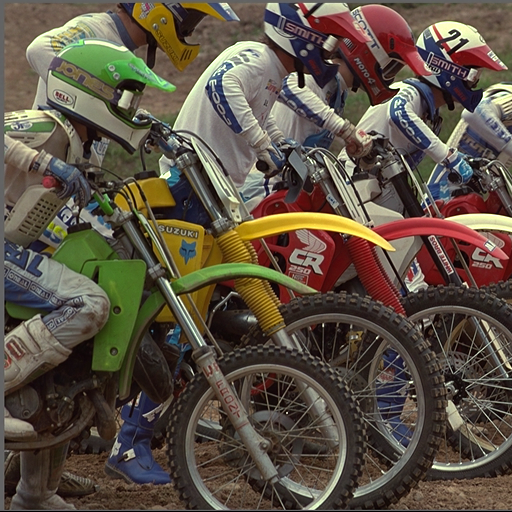

In [3]:
model.eval()
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)
y_padded = CenterCrop((y.shape[1]+config.F, y.shape[2]+config.F))(y)
Y = compand(mdct2d(y_padded, 2*config.F, 2*config.F))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (u v c) h w').unsqueeze(0)
with torch.no_grad():
    latent = model.noise_injection(model.conv_down(inputs))
webp_bytes = entropy_code(latent)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes}x compression ratio")
print(f"{y.numel()/latent.numel()}x dimension reduction")
latent_decoded = entropy_decode(webp_bytes).to(device)
outputs = model.conv_up(model.noise_injection.scale(latent_decoded))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(u v c) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
y_hat = (y_hat).clamp(-1,1)

PSNR = -10*torch.nn.functional.mse_loss(y/2,y_hat/2).log10()
print(f"{PSNR.item()} dB PSNR")

ToPILImage()(y_hat/2+0.5)

21.166810989379883 PSNR
12K	test.jpg


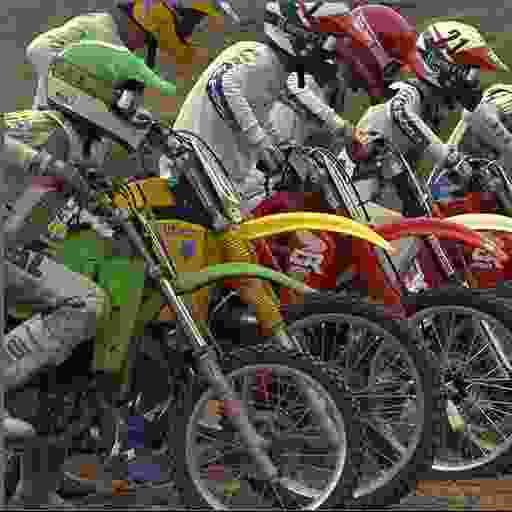

In [4]:
img.crop((0,0,512,512)).save("test.jpg",quality=5)
jpeg = PIL.Image.open("test.jpg")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, y.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.jpg
display(jpeg)

42.80809783935547 PSNR
276K	test.jpg


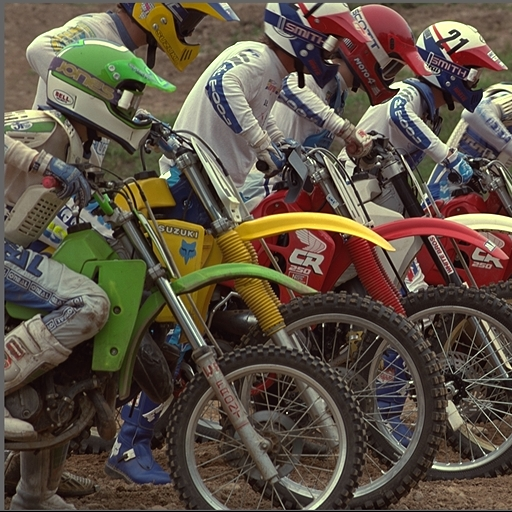

In [5]:
img.crop((0,0,512,512)).save("test.jpg",quality=100)
jpeg = PIL.Image.open("test.jpg")
MSE = torch.nn.functional.mse_loss(PILToTensor()(jpeg).to(torch.float)/255, y.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.jpg
display(jpeg)

6.552 KB
120.02930402930403x compression ratio
97.52380952380952x dimension reduction
11.893716812133789 dB PSNR


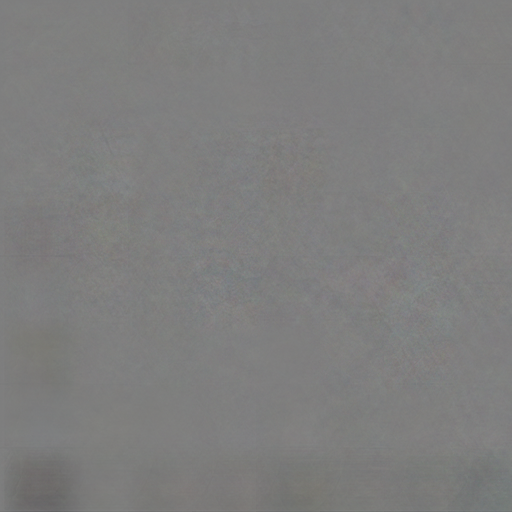

In [6]:
model.eval()
img = PIL.Image.open("kodim14.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)
y_padded = CenterCrop((y.shape[1]+config.F, y.shape[2]+config.F))(y)
Y = compand(mdct2d(y_padded, 2*config.F, 2*config.F))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (u v c) h w').unsqueeze(0)
with torch.no_grad():
    latent = model.noise_injection(model.conv_down(inputs))
webp_bytes = entropy_code(latent)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes}x compression ratio")
print(f"{y.numel()/latent.numel()}x dimension reduction")
latent_decoded = entropy_decode(webp_bytes).to(device)
outputs = model.conv_up(model.noise_injection.scale(latent_decoded))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(u v c) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
y_hat = (y_hat).clamp(-1,1)

PSNR = -10*torch.nn.functional.mse_loss(y/2,y_hat/2).log10()
print(f"{PSNR.item()} dB PSNR")

ToPILImage()(y_hat/2+0.5)